## Import packages

In [82]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

import os
import pandas as pd

# from PIL import Image
import rasterio

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]


# Import the data and set up the dataset and dataloader

In [83]:
class buffalo_data(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.npy_base_path = '../'

        # Ensure scalar columns are numeric and convert to tensors directly
        scalar_columns = ['hour_t2_sin', 'hour_t2_cos', 'yday_t2_sin', 'yday_t2_cos']
        self.data[scalar_columns] = self.data[scalar_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
        self.scalar_to_grid_data = torch.from_numpy(self.data[scalar_columns].values).float()

        # Ensure bearing is numeric and convert to tensor directly
        self.data['bearing'] = pd.to_numeric(self.data['bearing'], errors='coerce').fillna(0)
        self.bearing_x = torch.from_numpy(self.data[['bearing']].values).float()


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, index):
        # Load the input .tif files and stack them
        ndvi_path = os.path.join(self.npy_base_path, self.data.iloc[index]['ndvi_filename'])
        canopy_path = os.path.join(self.npy_base_path, self.data.iloc[index]['canopy_filename'])
        herby_path = os.path.join(self.npy_base_path, self.data.iloc[index]['herby_filename'])
        slope_path = os.path.join(self.npy_base_path, self.data.iloc[index]['slope_filename'])

        # with rasterio.open(ndvi_path) as src:
        #     ndvi_tens = torch.tensor(src.read(), dtype=torch.float32)
        # with rasterio.open(canopy_path) as src:
        #     canopy_tens = torch.tensor(src.read(), dtype=torch.float32)
        # with rasterio.open(herby_path) as src:
        #     herby_tens = torch.tensor(src.read(), dtype=torch.float32)
        # with rasterio.open(slope_path) as src:
        #     slope_tens = torch.tensor(src.read(), dtype=torch.float32)

        ndvi_npy = np.load(ndvi_path)
        ndvi_npy = np.nan_to_num(ndvi_npy, nan=-1.0) # Replace NaNs in the original array with -1, which represents water
        ndvi_tens = torch.tensor(ndvi_npy, dtype=torch.float32)
        canopy_tens = torch.tensor(np.load(canopy_path), dtype=torch.float32)
        herby_tens = torch.tensor(np.load(herby_path), dtype=torch.float32)
        slope_npy = np.load(slope_path)
        slope_npy = np.nan_to_num(slope_npy, nan=0.0) # Replace NaNs in the original array with 0
        slope_tens = torch.tensor(slope_npy, dtype=torch.float32) 

        spatial_data_x = torch.stack([ndvi_tens, canopy_tens, herby_tens, slope_tens], dim=1).squeeze()

        # Load the scalar values and bearing
        scalar_to_grid_data = self.scalar_to_grid_data[index]
        bearing_x = self.bearing_x[index]

        # Load the target .tif file
        target_path = os.path.join(self.npy_base_path, self.data.iloc[index]['pres_filename'])
        # with rasterio.open(target_path) as src:
        #     target = torch.tensor(src.read(), dtype=torch.float32)
        target = torch.tensor(np.load(target_path), dtype=torch.float32)

        return spatial_data_x, scalar_to_grid_data, bearing_x, target


In [84]:
# Example usage
csv_file = '../data_layers_single/buffalo_all_101x101_data_df_lag_1hr_n103630_npy.csv'
dataset = buffalo_data(csv_file)

training_split = 0.8
validation_split = 0.1
test_split = 0.1

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [training_split, validation_split, test_split])
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))

82904
10363
10363


### Create dataloaders

In [63]:
bs = 128 # batch size
dataloader_train = DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=bs, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=bs, shuffle=True)

Feature x1 batch shape: torch.Size([128, 4, 101, 101])
Feature x2 batch shape: torch.Size([128, 4])
Feature x3 batch shape: torch.Size([128, 1])
Labels batch shape: torch.Size([128, 1, 101, 101])
tensor([ 0.8660,  0.5000,  0.4405, -0.8977])
[-1.1239653]


Text(0.5, 1.0, 'Local Slope')

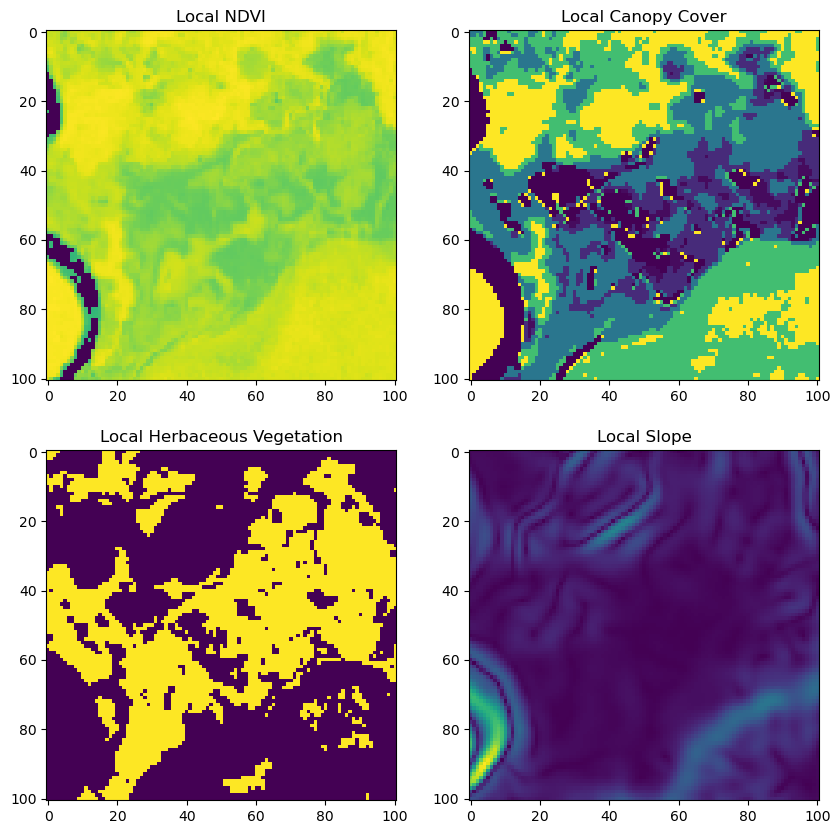

In [189]:
# Display image and label.
x1, x2, x3, labels = next(iter(dataloader_train))
print(f"Feature x1 batch shape: {x1.size()}")
print(f"Feature x2 batch shape: {x2.size()}")
print(f"Feature x3 batch shape: {x3.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2[0,:])
print(x3[0,:].detach().numpy())

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(x1.detach().numpy()[0,0,:,:], cmap='viridis')
axs[0, 0].set_title('Local NDVI')
axs[0, 1].imshow(x1.detach().numpy()[0,1,:,:], cmap='viridis')
axs[0, 1].set_title('Local Canopy Cover')
axs[1, 0].imshow(x1.detach().numpy()[0,2,:,:], cmap='viridis')
axs[1, 0].set_title('Local Herbaceous Vegetation')
axs[1, 1].imshow(x1.detach().numpy()[0,3,:,:], cmap='viridis')
axs[1, 1].set_title('Local Slope')

Plot with colour scale

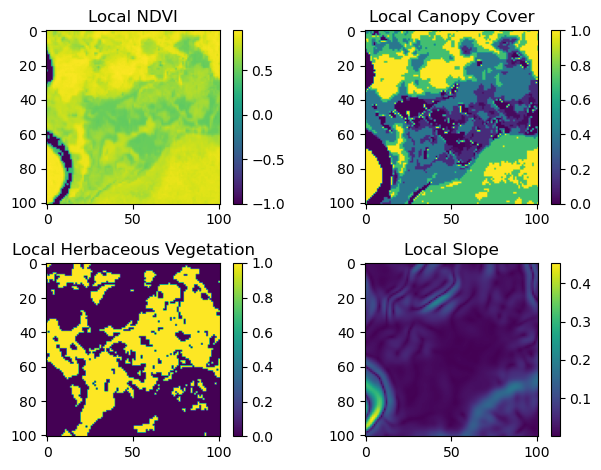

In [190]:
fig, axs = plt.subplots(2, 2)

im1 = axs[0, 0].imshow(x1.detach().numpy()[0, 0, :, :], cmap='viridis')
axs[0, 0].set_title('Local NDVI')
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(x1.detach().numpy()[0, 1, :, :], cmap='viridis')
axs[0, 1].set_title('Local Canopy Cover')
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(x1.detach().numpy()[0, 2, :, :], cmap='viridis')
axs[1, 0].set_title('Local Herbaceous Vegetation')
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(x1.detach().numpy()[0, 3, :, :], cmap='viridis')
axs[1, 1].set_title('Local Slope')
fig.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [65]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Define the model

In [92]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)
    

class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)
        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )
    
    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )
    
    def forward(self, x):
        return self.ffn(x)
    
class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )
    
    def forward(self, x):
        return self.ffn(x)


class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale
    
    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))
    

    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        # bearing_new1 = x[:, 6] + bearing[:, 0]
        bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 6]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        # bearing_new2 = x[:, 9] + bearing[:, 0]
        bearing_new2 = torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 9]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))
        vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # normalise so the densities sum to 1 when exponentiated
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)
        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid
    

class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x
    
        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        # self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output
    

class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [93]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 10, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

### Create some random covariates to test the model

tensor([[0.0828, 0.1256, 0.5775, 0.0137],
        [0.2225, 0.0976, 0.3085, 0.5854],
        [0.5066, 0.7443, 0.9039, 0.7448],
        [0.6390, 0.3626, 0.4359, 0.4582],
        [0.2044, 0.7610, 0.9632, 0.5345]])
tensor([[0.3901],
        [0.7530],
        [0.4857],
        [0.0224],
        [0.8292]])


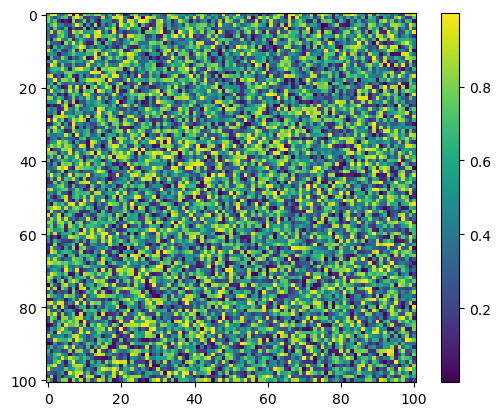

In [94]:
test_batch = 5
x1 = (torch.rand(test_batch, 4, 101, 101, device=device)) #spatial data
x2 = (torch.rand(test_batch, 4, device=device)) #other scalar covariates
x3 = (torch.rand(test_batch, 1, device=device)) # bearing
print(x2)
print(x3)

# plot the results of the movement density as an image
plt.imshow(x1.detach().cpu().numpy()[0, 0, :,:])
plt.colorbar()
plt.show()

# synth_ds = TensorDataset(x1, x2, y)
# synth_dl = DataLoader(synth_ds, batch_size=1, shuffle=True)

torch.Size([5, 101, 101, 2])


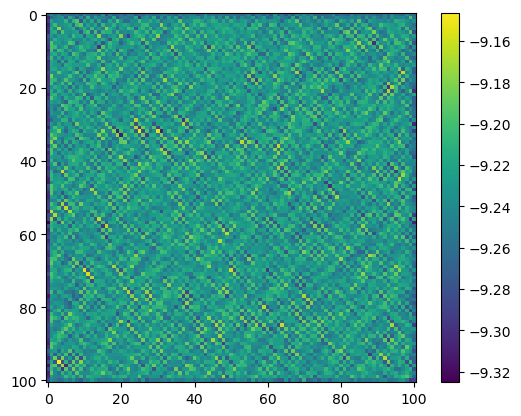

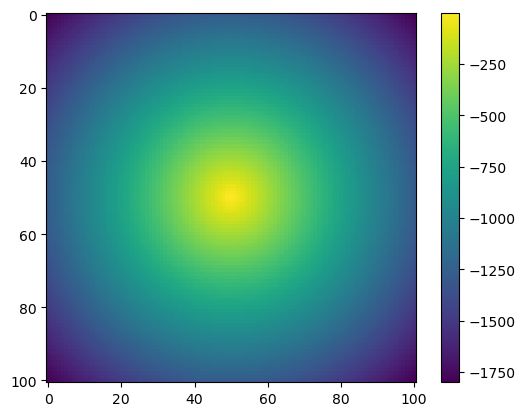

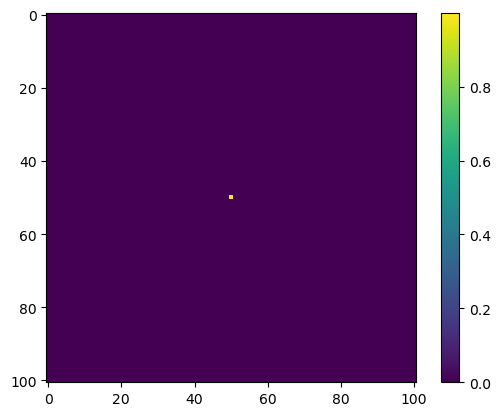

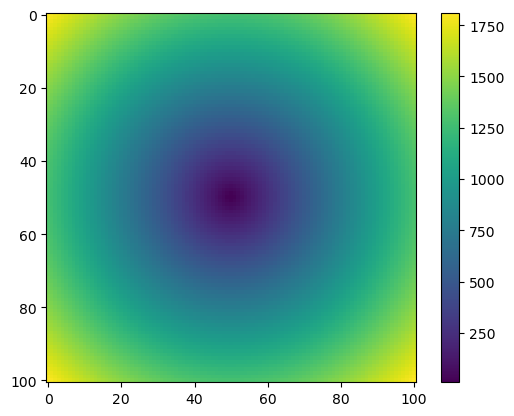

In [95]:
#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# plot the results of the habitat density as an image
plt.imshow(test.detach().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# plot the results of the exp movement density as an image
plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = -1 * (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
# test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

plt.imshow(test_cat.detach().numpy()[0,:,:])
plt.colorbar()
plt.show()

### Testing the movement parameter block with known Gamma and von Mises parameters

tensor([[[-11.5304, -11.4874, -11.4449,  ..., -10.7148, -10.7495, -10.7851],
         [-11.4861, -11.4428, -11.4001,  ..., -10.6624, -10.6975, -10.7334],
         [-11.4424, -11.3988, -11.3558,  ..., -10.6105, -10.6459, -10.6822],
         ...,
         [-11.4424, -11.3988, -11.3558,  ..., -10.6105, -10.6459, -10.6822],
         [-11.4861, -11.4428, -11.4001,  ..., -10.6624, -10.6975, -10.7334],
         [-11.5304, -11.4874, -11.4449,  ..., -10.7148, -10.7495, -10.7851]]],
       dtype=torch.float64)
torch.Size([1, 101, 101])


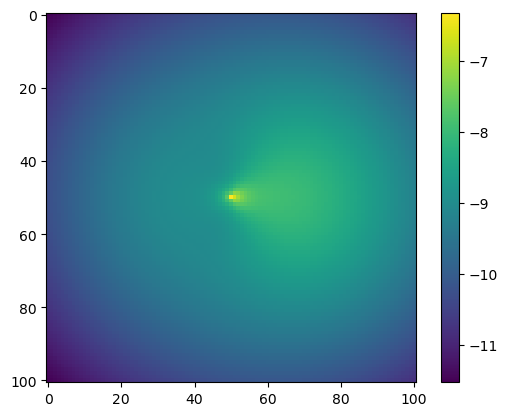

In [101]:
test_bearing = torch.tensor([[0.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
                                             np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
                                             np.log(1.5), np.log(0.75),
                                             np.log(0.5), np.log(0.25)]], device=device), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density[0])
plt.colorbar()
plt.show()

## Loss function and optimizer

In [102]:
# Custom loss function to work with the two heatmaps that the model outputs

class negativeLogLikeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(negativeLogLikeLoss, self).__init__()
        assert reduction in ['mean', 'sum', 'none'], "reduction should be 'mean', 'sum', or 'none'"
        self.reduction = reduction  # Assign reduction to self.reduction
    
    def forward(self, predict, target):
        predict_prod = predict[:, :, :, 0] + predict[:, :, :, 1]          # elementwise summation of the two heatmaps - for log-densities
        # predict_prod = predict[:, :, :, 0]*predict[:, :, :, 1]          # elementwise product of the two heatmaps
        # predict_prod = predict_prod/torch.sum(predict_prod)             # normalise the product of the two heatmaps
        # negLogLike = -1*(predict_prod * target)
        
        # Check for NaNs in the product
        if torch.isnan(predict_prod).any():
            print("NaNs detected in predict_prod")
            print("predict_prod:", predict_prod)
            raise ValueError("NaNs detected in predict_prod")
        
        # predict_prod = predict_prod / torch.sum(predict_prod)  # normalise the product of the two heatmaps
        
        # Check for NaNs after normalization
        # if torch.isnan(predict_prod).any():
        #     print("NaNs detected after normalization")
        #     print("predict_prod:", predict_prod)
        #     raise ValueError("NaNs detected after normalization")
        
        negLogLike = -1 * (predict_prod * target)
        # negLogLike = -1 * torch.log(predict_prod * target)
        
        # Check for NaNs in the negative log likelihood
        if torch.isnan(negLogLike).any():
            print("NaNs detected in negLogLike")
            print("negLogLike:", negLogLike)
            raise ValueError("NaNs detected in negLogLike")

        if self.reduction == 'mean':
            return torch.mean(negLogLike)
        elif self.reduction == 'sum':
            return torch.sum(negLogLike)
        elif self.reduction == 'none':
            return negLogLike
        return negLogLike

### Early stopping code

In [103]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Instantiate the model

In [162]:
params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

# # save the model structure
# torch.save(model, 'CNN_model_global.pth')

learning_rate = 1e-3
loss_fn = negativeLogLikeLoss(reduction='mean')

# path to save the model weights
path_save_weights = 'checkpoint_CNN_buffalo_all_TAmixVMmu.pt'

optimiser = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=3)
early_stopping = EarlyStopping(patience=10, verbose=True, path = path_save_weights) # , delta=early_stopping_delta

## Training loop

In [117]:
def train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler):
    size = len(dataloader_train.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    epoch_loss = 0.0
    # val_loss = 0.0
    # num_batches = len(dataloader_test)

    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):
        
        # calculate the loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # Backpropagation
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * bs + len(x1)
            print(f"loss: {loss:>15f}  [{current:>5d}/{size:>5d}]")

    # # Model validation to assess the learning rate
    # # Set the model to evaluation mode for the validation dataset
    # model.eval()
    # with torch.no_grad():
    #     for x1, x2, y in dataloader_val:
    #         val_loss += loss_fn(model((x1, x2)), y) 
         
    # scheduler.step(val_loss)

    # val_loss /= num_batches
    # print(f"\nAvg validation loss: {val_loss:>15f}")
    # print(f"Learning rate: {scheduler.get_last_lr()}")
    # # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")
    # return val_loss


def test_loop(dataloader_test, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_test:
            test_loss += loss_fn(model((x1, x2, x3)), y)

    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg test loss: {test_loss:>15f} \n")

## Train the model

In [166]:
epochs = 100

for t in range(epochs):

    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler)

    # Model validation to assess the learning rate
    # Set the model to evaluation mode for the validation dataset
    model.eval()
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_val:
            val_loss += loss_fn(model((x1, x2, x3)), y)    
    scheduler.step(val_loss)

    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")
    # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        #load the optimal model weights
        model.load_state_dict(torch.load(path_save_weights))
        test_loop(dataloader_test, model, loss_fn)
        break
    else:
        model.eval()
        print("\n")

    # test_loop(dataloader_test, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss:        0.001416  [  128/82904]
loss:        0.001507  [  256/82904]
loss:        0.001476  [  384/82904]
loss:        0.001446  [  512/82904]
loss:        0.001504  [  640/82904]
loss:        0.001464  [  768/82904]
loss:        0.001465  [  896/82904]
loss:        0.001543  [ 1024/82904]
loss:        0.001494  [ 1152/82904]
loss:        0.001475  [ 1280/82904]
loss:        0.001506  [ 1408/82904]
loss:        0.001457  [ 1536/82904]
loss:        0.001488  [ 1664/82904]
loss:        0.001453  [ 1792/82904]
loss:        0.001446  [ 1920/82904]
loss:        0.001475  [ 2048/82904]
loss:        0.001482  [ 2176/82904]
loss:        0.001470  [ 2304/82904]
loss:        0.001461  [ 2432/82904]
loss:        0.001443  [ 2560/82904]
loss:        0.001394  [ 2688/82904]
loss:        0.001425  [ 2816/82904]
loss:        0.001493  [ 2944/82904]
loss:        0.001491  [ 3072/82904]
loss:        0.001479  [ 3200/82904]
loss:        0.001481  [ 3328/82904

KeyboardInterrupt: 

In [169]:
print(model.state_dict())
model.load_state_dict(torch.load(path_save_weights))
# model.load_state_dict(torch.load('checkpoint_CNN_global_all.pt'))

OrderedDict([('conv_habitat.conv2d.0.weight', tensor([[[[ 2.8012e-02, -1.5293e-03,  5.8454e-02],
          [-6.5340e-02,  9.3905e-03,  5.3149e-02],
          [ 4.3317e-02, -1.7579e-02,  1.1098e-01]],

         [[ 5.7163e-04, -3.2522e-02, -9.3645e-02],
          [-1.9938e-03, -1.0323e-01, -4.0145e-02],
          [-1.2594e-01, -3.9784e-02, -1.0187e-01]],

         [[ 1.9200e-02, -4.2051e-02, -1.1490e-02],
          [-5.0900e-02,  5.3810e-02, -5.0728e-02],
          [ 2.0227e-02, -4.0509e-02,  2.9568e-02]],

         [[-4.4000e-01, -1.8425e-02,  4.0085e-01],
          [-4.0595e-01, -5.2376e-02,  5.2278e-01],
          [-3.9523e-01, -9.3173e-02,  3.6810e-01]],

         [[ 6.6327e-01, -1.2666e-01,  5.5844e-01],
          [-2.2287e-02, -5.2308e-01, -4.0129e-02],
          [ 7.1294e-01,  6.9812e-02,  5.6863e-01]],

         [[ 2.6089e-01,  5.2018e-02,  9.0216e-02],
          [ 1.1803e-01, -3.2593e-02, -4.2614e-02],
          [ 1.7344e-01,  9.6525e-02,  2.0837e-01]],

         [[-2.5574e-02, 

<All keys matched successfully>

## View model outputs

### Adding hooks to look at intermediate model outputs

In [120]:
# # Define a hook function to collect intermediate activations
# activations = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activations[name] = output.detach()
#     return hook

# # Register hooks for intermediate layers
# model.conv_habitat.conv2d.register_forward_hook(get_activation('conv_habitat'))
# # net.conv1.register_forward_hook(get_activation('conv1'))
# # net.conv2.register_forward_hook(get_activation('conv2'))
# # net.conv3.register_forward_hook(get_activation('conv3'))

### Run model forward

Feature x1 batch shape: torch.Size([128, 4, 101, 101])
Feature x2 batch shape: torch.Size([128, 4])
Feature x3 batch shape: torch.Size([128, 1])
Labels batch shape: torch.Size([128, 1, 101, 101])
[ 0.9659258  -0.25881904 -0.9922222   0.12447926]
Hour  6.999999967119774
Day of the year  281.0000015519003
Bearing  2.9042664


Text(0.5, 1.0, 'Local Slope')

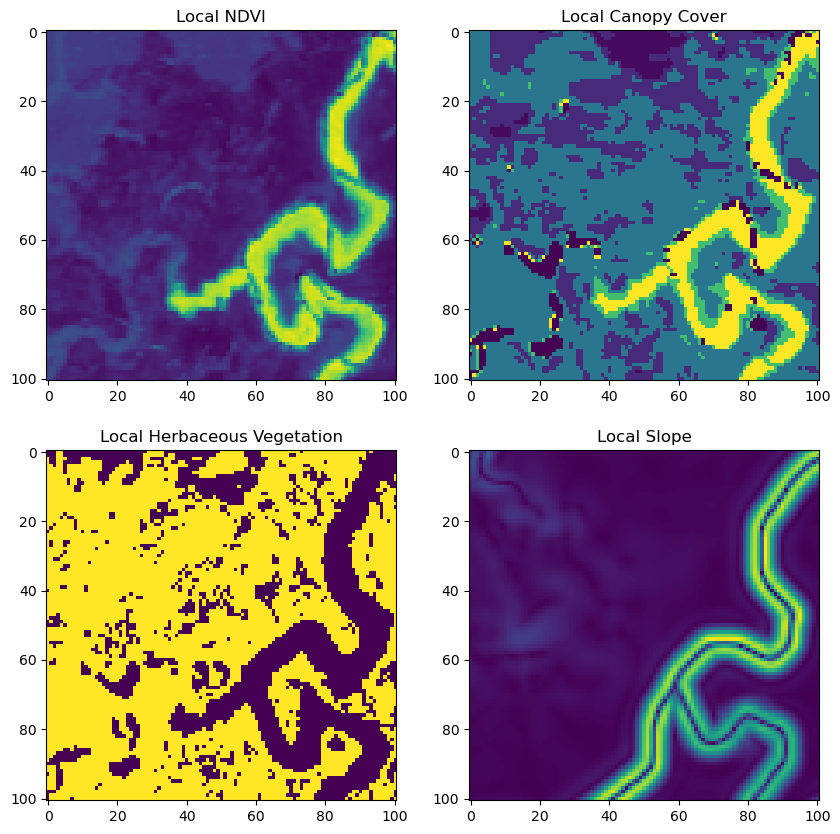

In [178]:
# 1. Set the model in evaluation mode
model.eval()

# Display image and label.
x1, x2, x3, labels = next(iter(dataloader_test))
print(f"Feature x1 batch shape: {x1.size()}")
print(f"Feature x2 batch shape: {x2.size()}")
print(f"Feature x3 batch shape: {x3.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2.detach().numpy()[0,:])

# Pull out the scalars
hour_t2_sin = x2.detach().numpy()[0,0]
hour_t2_cos = x2.detach().numpy()[0,1]
yday_t2_sin = x2.detach().numpy()[0,2]
yday_t2_cos = x2.detach().numpy()[0,3]
bearing = x3.detach().numpy()[0,0]

def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print('Hour ', hour_t2)

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print('Day of the year ', yday_t2)

print('Bearing ', bearing)
# print(loss_fn(model((x1, x2, x3)), labels))

# Plot the local covariate layers
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(x1.detach().numpy()[0,0,:,:], cmap='viridis')
axs[0, 0].set_title('Local NDVI')
axs[0, 1].imshow(x1.detach().numpy()[0,1,:,:], cmap='viridis')
axs[0, 1].set_title('Local Canopy Cover')
axs[1, 0].imshow(x1.detach().numpy()[0,2,:,:], cmap='viridis')
axs[1, 0].set_title('Local Herbaceous Vegetation')
axs[1, 1].imshow(x1.detach().numpy()[0,3,:,:], cmap='viridis')
axs[1, 1].set_title('Local Slope')


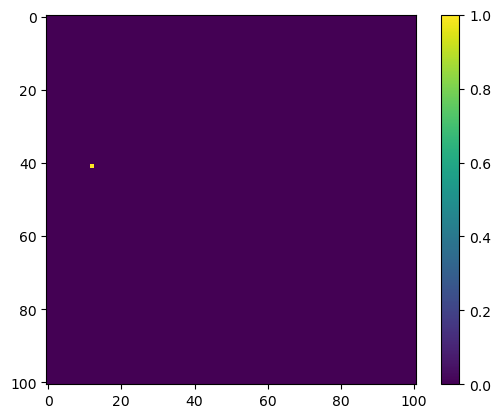

torch.Size([128, 101, 101, 2])


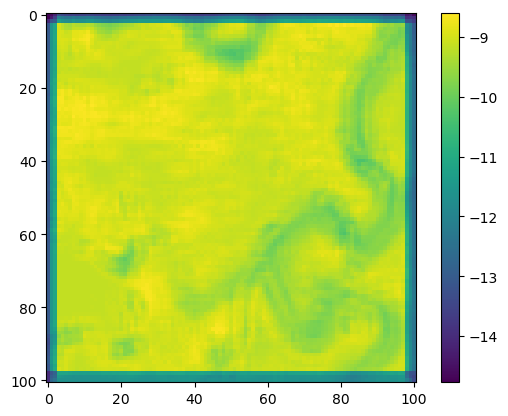

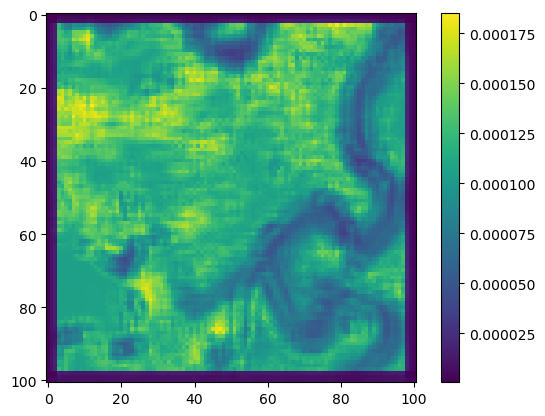

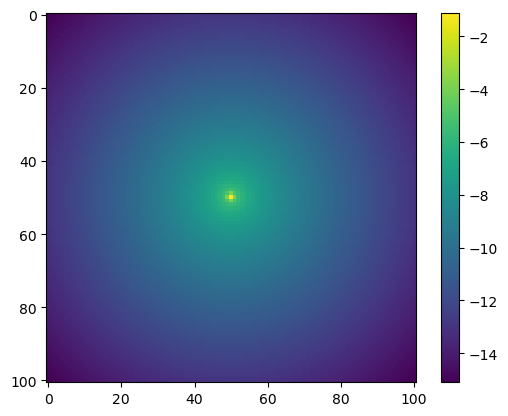

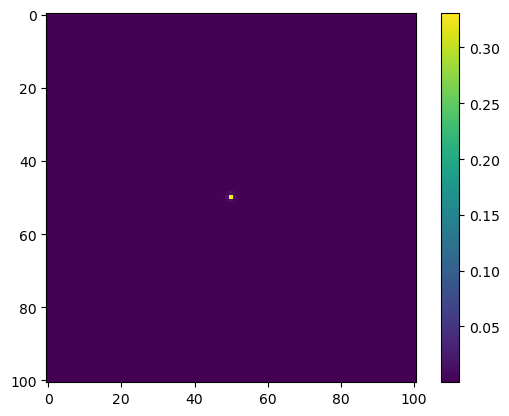

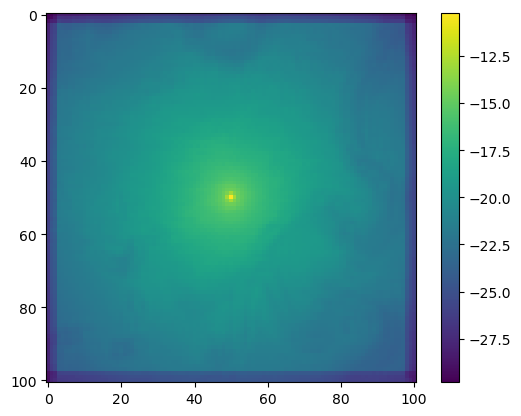

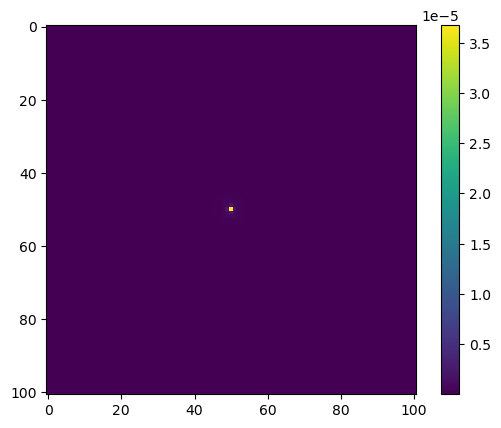

In [179]:
# plot the target
plt.imshow(labels.detach().numpy()[0,0,:,:])
plt.colorbar()
plt.show()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,0])))

# plot the results of the habitat density as an image - in log scale
plt.imshow(test.detach().numpy()[0,:,:,0])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

# plot the results of the habitat density as an image - as probabilities
# plt.imshow(test.detach().numpy()[0,:,:,0])
plt.imshow(np.exp(test.detach().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

# plot the results of the movement density as an image - in log scale
plt.imshow(test.detach().numpy()[0,:,:,1])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

# plot the results of the movement density as an image - as probabilities
# plt.imshow(test.detach().numpy()[0,:,:,1])
plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

# results of the habitat and movement densities
# log-scale
test_cat = test[0, :, :, 0] + test[0, :, :, 1]
plt.imshow(test_cat.detach().numpy()[:,:])
plt.colorbar()
plt.show()

# exponentiated
test_cat = torch.exp(test[0, :, :, 0] + test[0, :, :, 1])
plt.imshow(test_cat.detach().numpy()[:,:])
plt.colorbar()
plt.show()

### Adding hooks to check movement parameters

In [180]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Print the intermediate output
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
# gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]


# Gamma 1 parameters
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:", torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Gamma 2 parameters
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2))
print("Gamma weight 2:", torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))
      
# Von Mises 1 parameters
# print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:", torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))
      
# Von Mises 2 parameters
# print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:", torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Intermediate output shape: torch.Size([128, 10])
Intermediate output values: tensor([-4.4324,  5.6552, -8.3126,  0.3448,  1.1242, -0.2075, -3.9600, -1.0619,
        -3.7492, -1.3658])
Gamma shape 1: tensor(0.0119)
Gamma scale 1: tensor(285.7663)
Gamma weight 1: tensor(0.0003)
Gamma shape 2: tensor(1.4117)
Gamma scale 2: tensor(3.0776)
Gamma weight 2: tensor(0.9997)
Von Mises kappa 1: tensor(0.0191)
Von Mises weight 1: tensor(0.5754)
Von Mises kappa 2: tensor(0.0235)
Von Mises weight 2: tensor(0.4246)


Plot the distributions

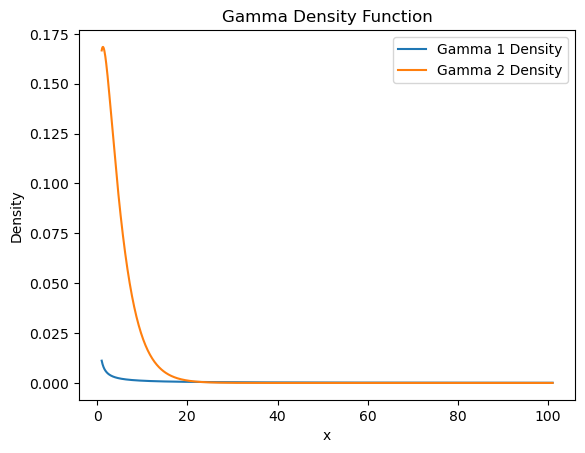

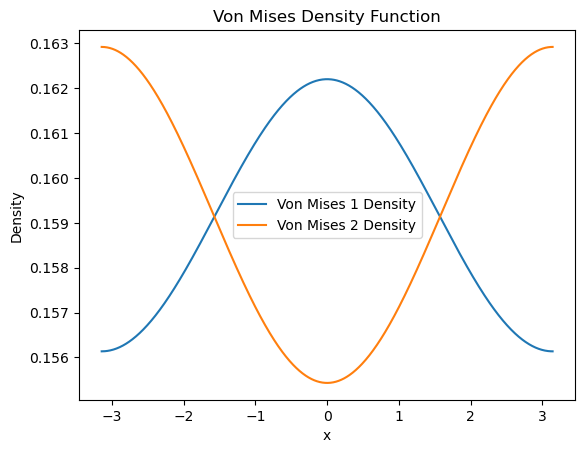

In [181]:
# Gamma densities for the mixture distribution
def gamma_density(x, shape, scale):
    return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

# von Mises densities for the mixture distribution
def vonmises_density(x, kappa, vm_mu):
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


# parameters of the Gamma mixture distributions
# Generate x values from 1 to 1000
x_values = torch.linspace(1, 101, 1000)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2))

# Plot the gamma density function
plt.plot(x_values.numpy(), np.exp(gamma1_density.numpy()), label='Gamma 1 Density')
plt.plot(x_values.numpy(), np.exp(gamma2_density.numpy()), label='Gamma 2 Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma Density Function')
plt.legend()
plt.show()

# parameters of the von mises mixture distribution
# Generate x values from -pi to pi
x_values = torch.linspace(-np.pi, np.pi, 1000)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), 0)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), torch.pi)

# Plot the von mises density function
plt.plot(x_values.numpy(), np.exp(vonmises1_density.numpy()), label='Von Mises 1 Density')
plt.plot(x_values.numpy(), np.exp(vonmises2_density.numpy()), label='Von Mises 2 Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Von Mises Density Function')
plt.legend()
plt.show()

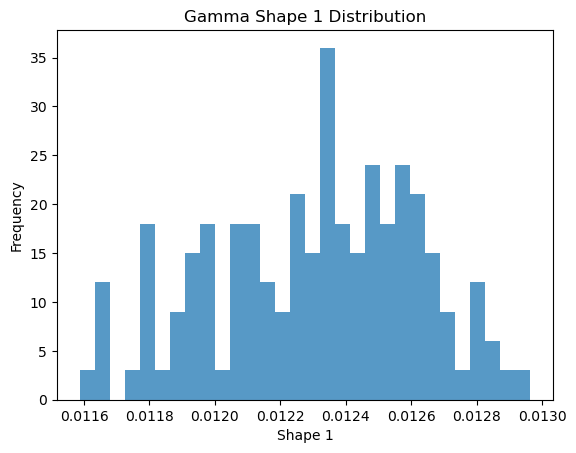

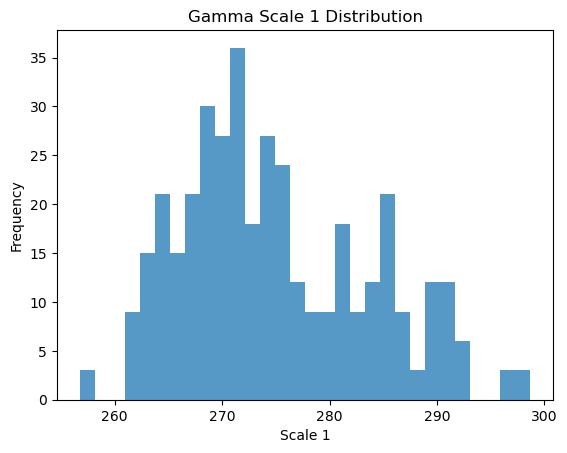

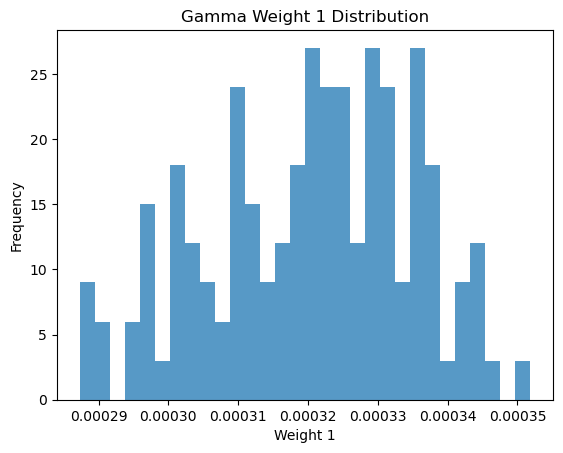

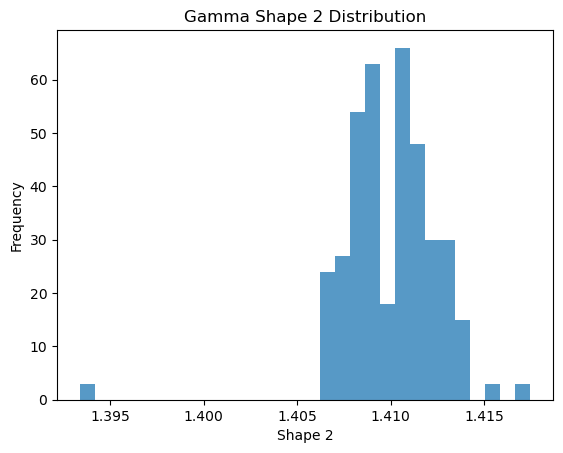

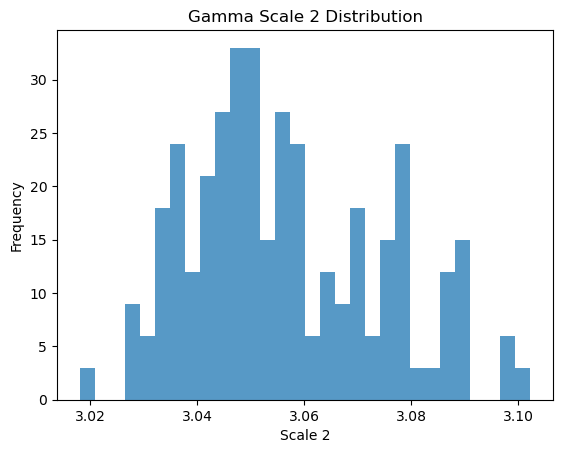

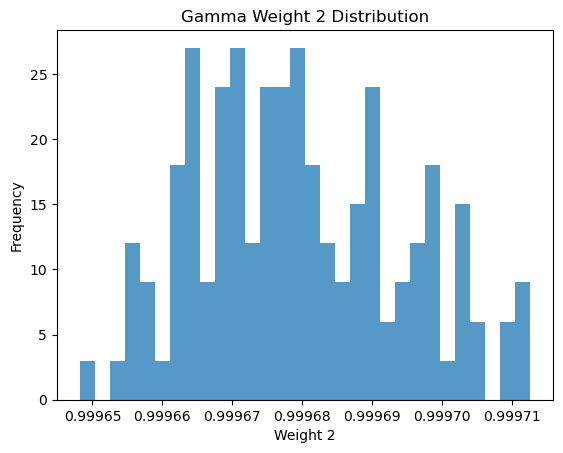

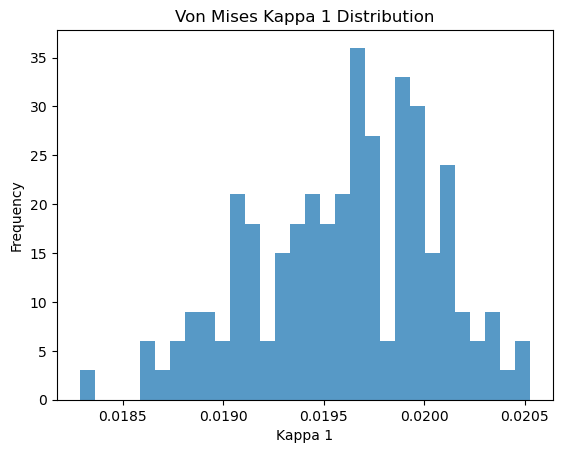

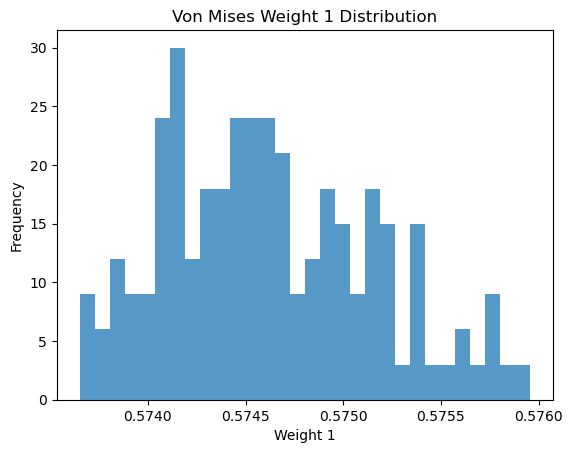

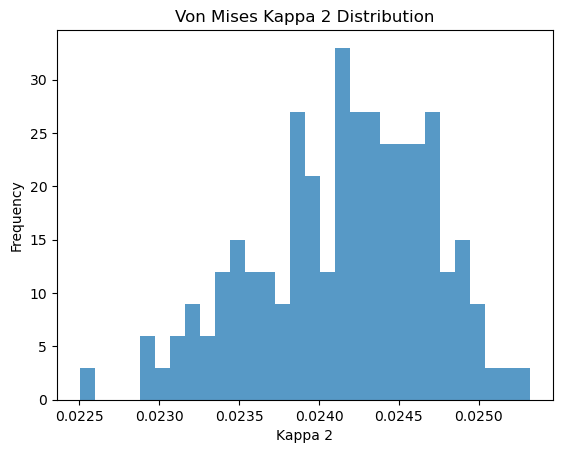

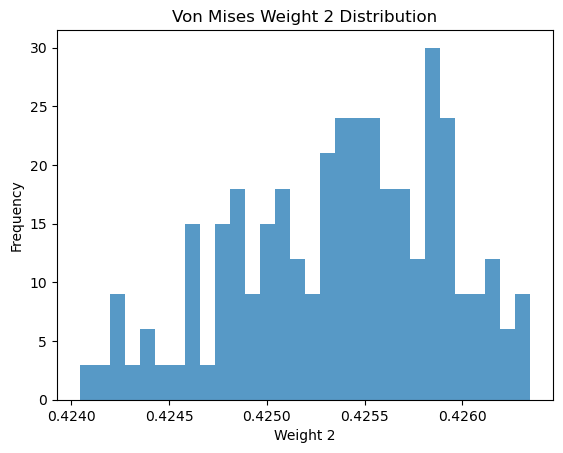

In [182]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Extract parameters for each batch
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
# vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
# vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

for batch_output in intermediate_output:
    for sample_output in batch_output:
        # gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output
        gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = sample_output

        gamma_shape1_list.append(torch.exp(gamma_shape1).item())
        gamma_scale1_list.append(torch.exp(gamma_scale1).item())
        gamma_weight1_list.append((torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
        gamma_shape2_list.append(torch.exp(gamma_shape2).item())
        gamma_scale2_list.append(torch.exp(gamma_scale2).item())
        gamma_weight2_list.append((torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
        # vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
        vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
        vonmises_weight1_list.append((torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())
        # vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
        vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
        vonmises_weight2_list.append((torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())

# Remove hook
hook_handle.remove()

# Plot parameters
def plot_histogram(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
# plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
# plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# Remove hook
hook_handle.remove()

tensor([[[-15.1022, -15.0307, -14.9599,  ..., -14.9611, -15.0319, -15.1033],
         [-15.0307, -14.9585, -14.8869,  ..., -14.8880, -14.9597, -15.0319],
         [-14.9600, -14.8869, -14.8144,  ..., -14.8156, -14.8881, -14.9612],
         ...,
         [-14.9616, -14.8886, -14.8161,  ..., -14.8169, -14.8893, -14.9624],
         [-15.0324, -14.9602, -14.8886,  ..., -14.8893, -14.9610, -15.0332],
         [-15.1039, -15.0325, -14.9617,  ..., -14.9624, -15.0332, -15.1047]]],
       dtype=torch.float64)
torch.Size([1, 101, 101])


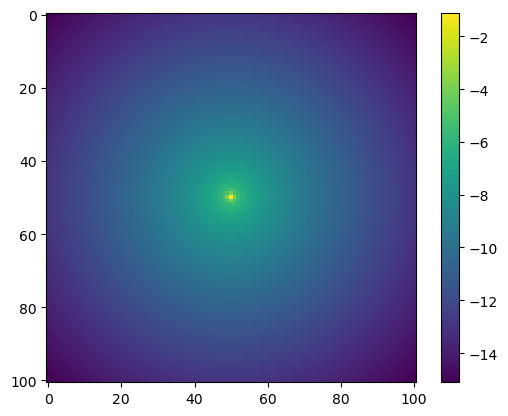

In [183]:
test_bearing = torch.tensor([[1.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
#                                              np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
#                                              5, np.log(1), np.log(0.75),
#                                              -10, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

movement_density = test_block(intermediate_output[0][0].unsqueeze(dim = 0), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density[0])
plt.colorbar()
plt.show()

### Visualise CNN layers

In [184]:
# Visualize the intermediate activations
# for layer_name, activation in activations.items():
#     print(f'Layer: {layer_name}, Shape: {activation.shape}')
#     plt.imshow(activation[0, 0].cpu().numpy(), cmap='gray')
#     plt.title(layer_name)
#     plt.show()